In [239]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
#from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)

Python:  3.9.0 (default, Nov  8 2020, 11:02:52) 
[Clang 12.0.0 (clang-1200.0.32.21)]
pandas:  1.2.3
numpy:  1.19.4
seaborn:  0.11.1
matplotlib:  3.3.4
sklearn:  0.24.2
Keras:  2.6.0
Tensorflow:  2.6.0


In [240]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()

        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
        plt.figure(figsize=(10, 8))
        plt.plot(error, marker='o', ms=3.5, linestyle='',
                 label='Point')

        plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="r", zorder=100, label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

In [241]:
tensorlogs = ["art_daily_no_noise", #0
              "art_daily_nojump", #1
              "art_daily_jumpsdown",#2
              "art_daily_perfect_square_wave", #3
              "art_increase_spike_density",  #4
              "art_load_balancer_spikes",  #5
              "ambient_temperature_system_failure", #6
              "nyc_taxi",  #7
              "ec2_cpu_utilization", #8
              "rds_cpu_utilization",
              "CombinedMacroSectorv4"] #10

dataFilePaths = ['data/art_daily_no_noise.csv',
                 'data/art_daily_nojump.csv',
                 'data/art_daily_jumpsdown.csv',
                 'data/art_daily_perfect_square_wave.csv',
                 'data/art_increase_spike_density.csv',
                 'data/art_load_balancer_spikes.csv',
                 'data/ambient_temperature_system_failure.csv',
                 'data/nyc_taxi.csv',
                 'data/ec2_cpu_utilization.csv',
                 'data/rds_cpu_utilization.csv',
                 'data/CombinedMacroSectorv4.csv']

In [242]:

i = 10
column = 'Real Estate' #value Oil, CPI, Technology, Real Estate, Industrials

tensorlog = tensorlogs[i]
dataFilePath = dataFilePaths[i]
print("tensorlog: ", tensorlog)
print("dataFilePath: ", dataFilePath)

tensorlog:  CombinedMacroSectorv4
dataFilePath:  data/CombinedMacroSectorv4.csv


In [243]:
missing_values = ["n/a", "na", "--", "null"]
date_cols = ['Date']
df = pd.read_csv(filepath_or_buffer=dataFilePath, header=0, na_values = missing_values, sep=',', parse_dates=date_cols)
print('Shape:' , df.shape[0])
print('Head:')
df['datetime'] = pd.to_datetime(df['Date'])
df = df.set_index('datetime')
#df.drop(['Date'], axis=1, inplace=True)
print(df.head(5))

Shape: 4275
Head:
                 Date    Oil  Inflation    CPI  Dollar Index  GDP  \
datetime                                                            
2004-09-29 2004-09-29  49.53       2.34  189.8     88.099998  3.8   
2004-09-30 2004-09-30  49.56       2.37  189.8     87.360001  3.8   
2004-10-01 2004-10-01  50.16       2.38  190.8     87.629997  4.1   
2004-10-04 2004-10-04  49.85       2.33  190.8     88.379997  4.1   
2004-10-05 2004-10-05  51.08       2.34  190.8     88.169998  4.1   

            Unemployment  Recession     Energy  Gold  ...  \
datetime                                              ...   
2004-09-29           5.4          0  34.720001   NaN  ...   
2004-09-30           5.4          0  34.930000   NaN  ...   
2004-10-01           5.5          0  35.430000   NaN  ...   
2004-10-04           5.5          0  35.389999   NaN  ...   
2004-10-05           5.5          0  35.770000   NaN  ...   

            Customer Discretionary  Consumer Staples     Health  Finan

In [244]:
df.dtypes

Date                      datetime64[ns]
Oil                              float64
Inflation                        float64
CPI                              float64
Dollar Index                     float64
GDP                              float64
Unemployment                     float64
Recession                          int64
Energy                           float64
Gold                             float64
Materials                        float64
Industrials                      float64
Customer Discretionary           float64
Consumer Staples                 float64
Health                           float64
Financials                       float64
Technology                       float64
Telecommunications               float64
Utilities                        float64
Real Estate                      float64
Cycle                             object
Spy                              float64
dtype: object

<AxesSubplot:xlabel='datetime'>

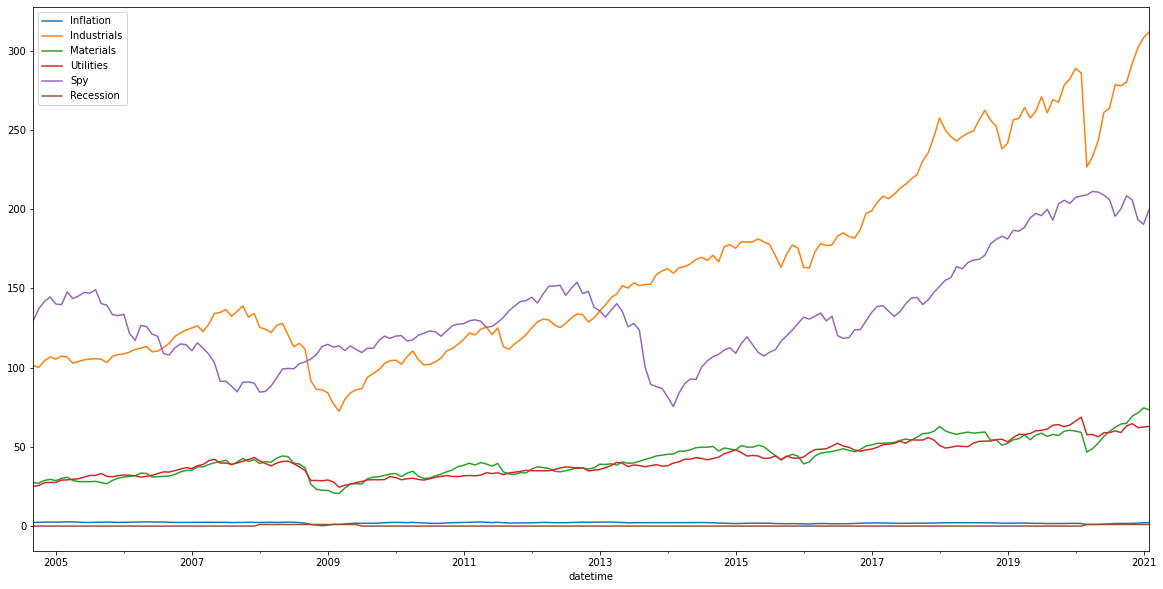

In [245]:
df.shape

monthly = df.resample('M')['Inflation','Industrials', 'Materials', 'Utilities', 'Spy', 'Recession']
monthly.mean().plot(figsize=(20,10))

<AxesSubplot:xlabel='datetime'>

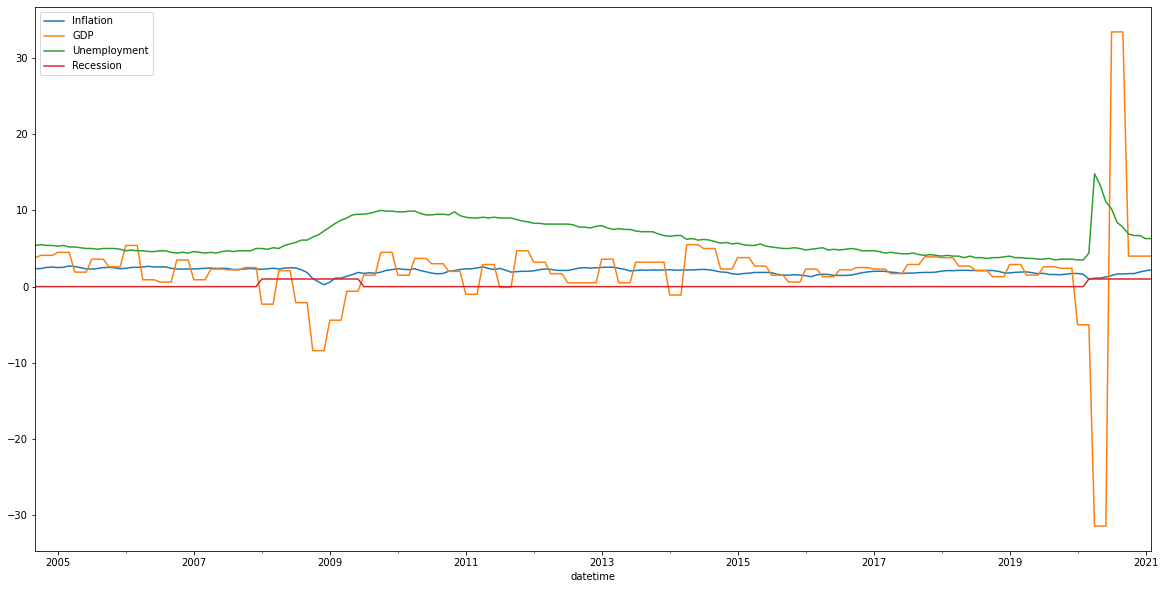

In [246]:
monthly = df.resample('M')['Inflation', 'GDP', 'Unemployment', 'Recession']
monthly.mean().plot(figsize=(20,10))

<AxesSubplot:xlabel='datetime'>

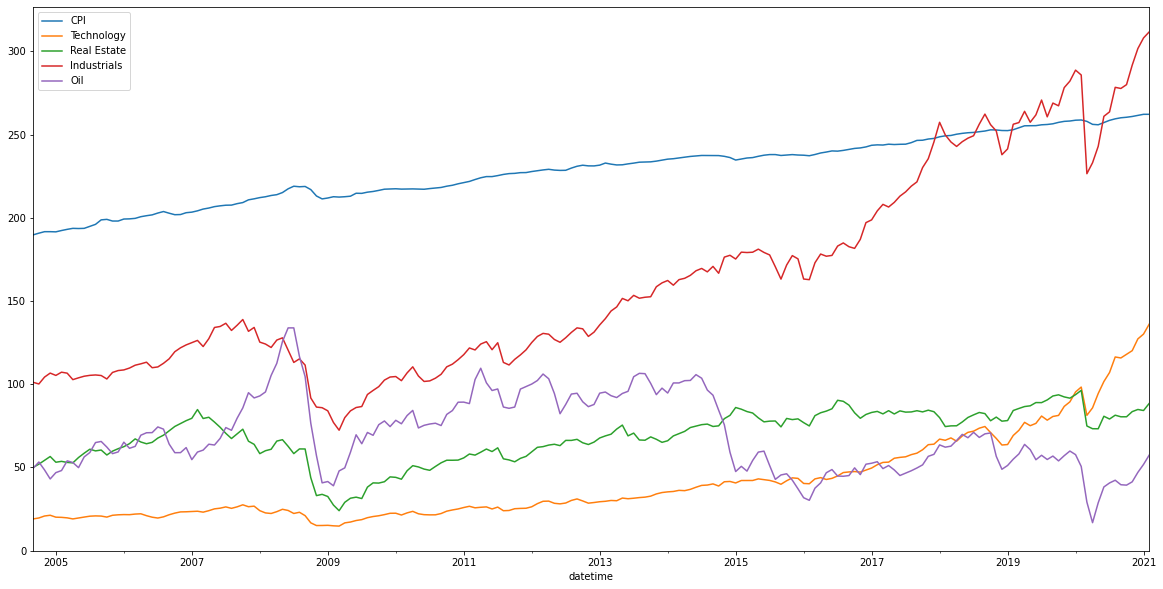

In [247]:
monthly = df.resample('M')['CPI', 'Technology', 'Real Estate', 'Industrials', 'Oil']
monthly.mean().plot(figsize=(20,10))

<AxesSubplot:title={'center':'Before Scaling'}, xlabel='Real Estate', ylabel='Density'>

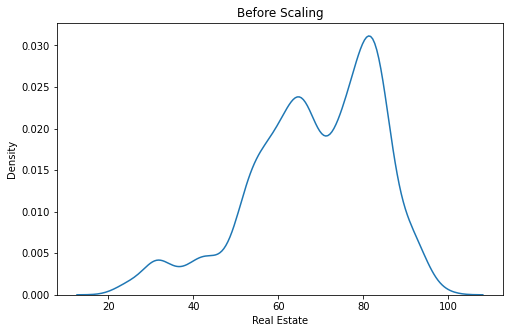

In [248]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df[column], ax=ax1)

In [249]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df['scaled_value'] = scaler.fit_transform(pd.DataFrame(df[column]))
print('Shape:' , df.shape[0])
df.head(5)

Shape: 4275


,Date,Oil,Inflation,CPI,Dollar Index,GDP,Unemployment,Recession,Energy,Gold,...,Consumer Staples,Health,Financials,Technology,Telecommunications,Utilities,Real Estate,Cycle,Spy,scaled_value
datetime,,,,,,,,,,,,,,,,,,,,,
2004-09-29,2004-09-29,49.53,2.34,189.8,88.099998,3.8,5.4,0,34.720001,NaN,...,21.610001,29.350000,23.176279,19.049999,22.680000,25.000000,49.849998,ExpandBeforePeak,129.00000,0.365978
2004-09-30,2004-09-30,49.56,2.37,189.8,87.360001,3.8,5.4,0,34.930000,NaN,...,21.660000,28.790001,23.119415,19.120001,22.620001,25.049999,50.250000,ExpandBeforePeak,130.09375,0.371079
2004-10-01,2004-10-01,50.16,2.38,190.8,87.629997,4.1,5.5,0,35.430000,NaN,...,21.879999,29.059999,23.509342,19.600000,22.990000,25.250000,51.180000,ExpandBeforePeak,129.43750,0.382938
2004-10-04,2004-10-04,49.85,2.33,190.8,88.379997,4.1,5.5,0,35.389999,NaN,...,21.830000,29.190001,23.541836,19.760000,23.309999,25.350000,51.400002,ExpandBeforePeak,127.81250,0.385743
2004-10-05,2004-10-05,51.08,2.34,190.8,88.169998,4.1,5.5,0,35.770000,NaN,...,21.830000,29.100000,23.411860,19.900000,23.400000,25.459999,51.389999,ExpandBeforePeak,130.12500,0.385616


<AxesSubplot:title={'center':'After Scaling'}, xlabel='scaled_value', ylabel='Density'>

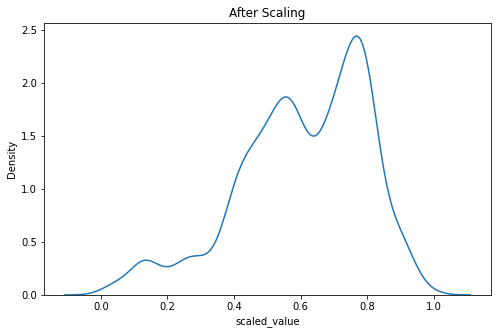

In [250]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('After Scaling')
sns.kdeplot(df['scaled_value'], ax=ax1)

In [251]:
time_steps = 15
metric = 'mean_absolute_error'

model = Sequential()
model.add(LSTM(units=32, activation='tanh', input_shape=(time_steps, 1), return_sequences=True))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 15, 32)            4352      
_________________________________________________________________
dense_12 (Dense)             (None, 15, 1)             33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [252]:
sequence = np.array(df['scaled_value'])
print(sequence)
time_steps = 15
samples = len(sequence)
trim = samples % time_steps
subsequences = int(samples/time_steps)
sequence_trimmed = sequence[:samples - trim]

print(samples, subsequences)
sequence_trimmed.shape = (subsequences, time_steps, 1)
print(sequence_trimmed.shape)

[0.36597804 0.37107881 0.38293803 ... 0.8727365  0.8727365  0.8639378 ]
4275 285
(285, 15, 1)


In [253]:

training_dataset = sequence_trimmed
print("training_dataset: ", training_dataset.shape)

batch_size=32
epochs=20

model.fit(x=training_dataset, y=training_dataset,
                       batch_size=batch_size, epochs=epochs,
                       verbose=1, validation_data=(training_dataset, training_dataset),
                       callbacks=[TensorBoard(log_dir='../logs/{0}'.format(tensorlog))])

training_dataset:  (285, 15, 1)
Epoch 1/20
9/9 [==============================] - 4s 142ms/step - loss: 0.1653 - mean_absolute_error: 0.1653 - val_loss: 0.1542 - val_mean_absolute_error: 0.1542
Epoch 2/20
9/9 [==============================] - 0s 20ms/step - loss: 0.1483 - mean_absolute_error: 0.1483 - val_loss: 0.1426 - val_mean_absolute_error: 0.1426
Epoch 3/20
9/9 [==============================] - 0s 21ms/step - loss: 0.1409 - mean_absolute_error: 0.1409 - val_loss: 0.1380 - val_mean_absolute_error: 0.1380

In [254]:
import math
from sklearn.metrics import mean_squared_error

sequence = np.array(df['scaled_value'])
print(sequence)
time_steps = 15
samples = len(sequence)
trim = samples % time_steps
subsequences = int(samples/time_steps)
sequence_trimmed = sequence[:samples - trim]

print(samples, subsequences)
sequence_trimmed.shape = (subsequences, time_steps, 1)
print(sequence_trimmed.shape)

testing_dataset = sequence_trimmed
print("testing_dataset: ", testing_dataset.shape)

testing_pred = model.predict(x=testing_dataset)
print("testing_pred: ", testing_pred.shape)

testing_dataset = testing_dataset.reshape((testing_dataset.shape[0]*testing_dataset.shape[1]), testing_dataset.shape[2])
print("testing_dataset: ", testing_dataset.shape)

testing_pred = testing_pred.reshape((testing_pred.shape[0]*testing_pred.shape[1]), testing_pred.shape[2])
print("testing_pred: ", testing_pred.shape)
errorsDF = testing_dataset - testing_pred
print(errorsDF.shape)
rmse = math.sqrt(mean_squared_error(testing_dataset, testing_pred))
print('Test RMSE: %.3f' % rmse)

[0.36597804 0.37107881 0.38293803 ... 0.8727365  0.8727365  0.8639378 ]
4275 285
(285, 15, 1)
testing_dataset:  (285, 15, 1)
testing_pred:  (285, 15, 1)
testing_dataset:  (4275, 1)
testing_pred:  (4275, 1)
(4275, 1)
Test RMSE: 0.083


In [255]:
#based on cutoff after sorting errors
dist = np.linalg.norm(testing_dataset - testing_pred, axis=-1)

scores =dist.copy()
print(scores.shape)
scores.sort()
cutoff = int(0.999 * len(scores))
print(cutoff)
#print(scores[cutoff:])
threshold= scores[cutoff]
print(threshold)

(4275,)
4270
0.40914500989254804


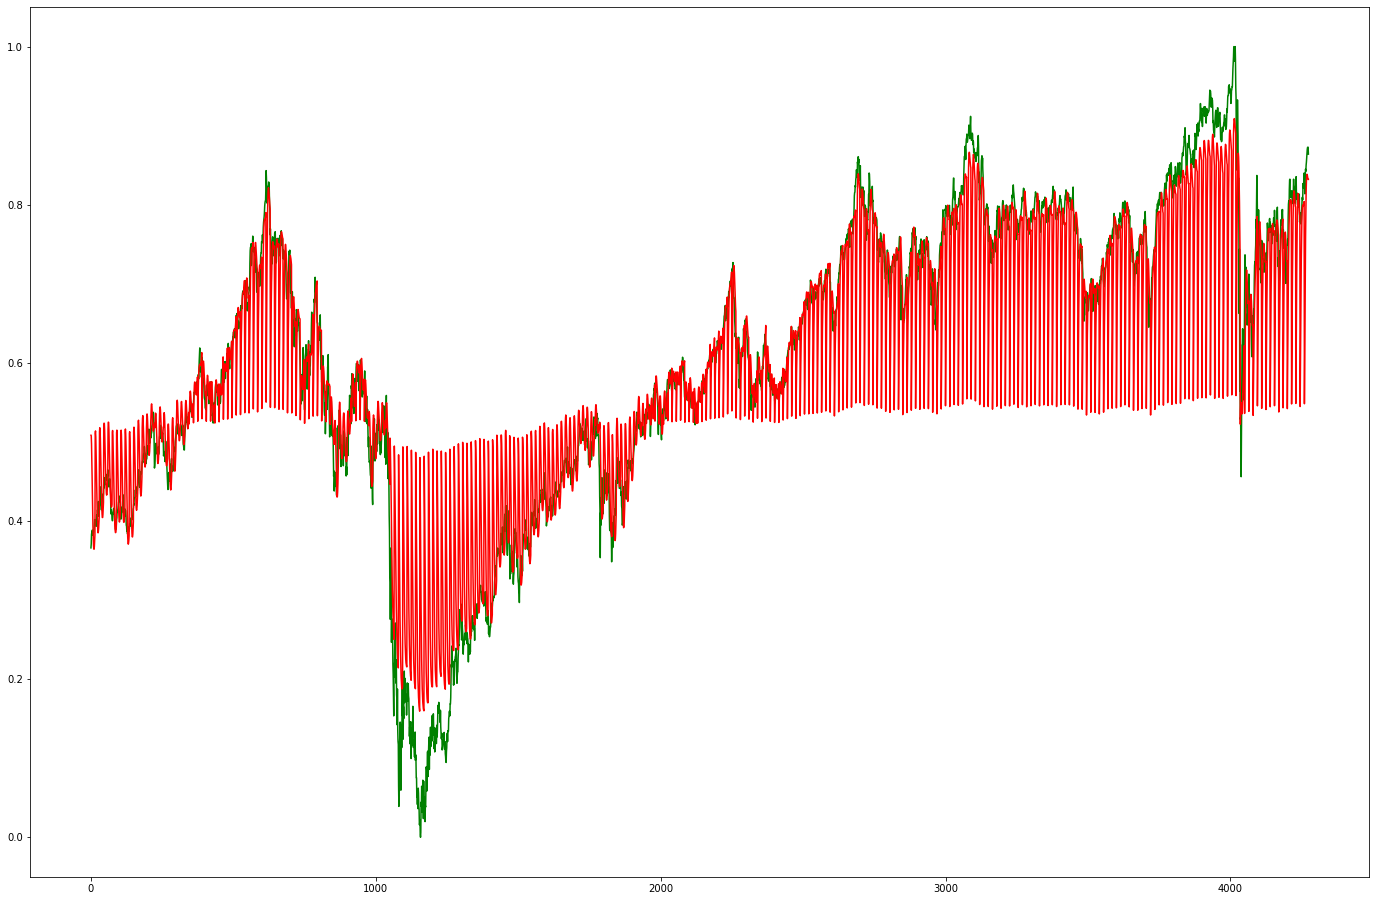

In [256]:

plt.figure(figsize=(24,16))
plt.plot(testing_dataset, color='green')
plt.plot(testing_pred, color='red')

In [257]:

#label the records anomalies or not based on threshold
z = zip(dist >= threshold, dist)

y_label=[]
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)

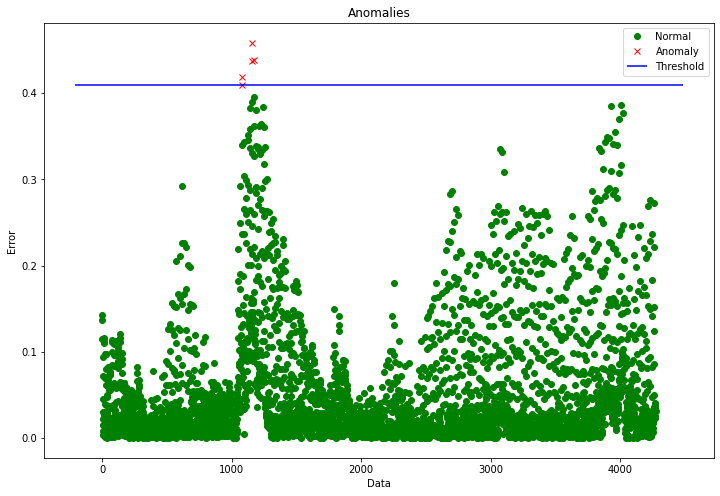

In [258]:
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)

In [259]:
print (len(error))
print (len(y_label))

adf = pd.DataFrame({'Date': df['Date'], 'observation': df[column],
                    'error': error, 'anomaly': y_label})

anom = adf.loc[adf['anomaly'] == 1]

anom.head(25)

4275
4275


,Date,observation,error,anomaly
datetime,,,,
2008-11-19,2008-11-19,26.290001,0.418096,1
2008-11-20,2008-11-20,24.209999,0.409145,1
2009-03-04,2009-03-04,22.850000,0.458462,1
2009-03-05,2009-03-05,21.440001,0.437440,1
2009-03-25,2009-03-25,24.580000,0.438157,1


Text(0.5, 1.0, 'Time Series of value by date time')

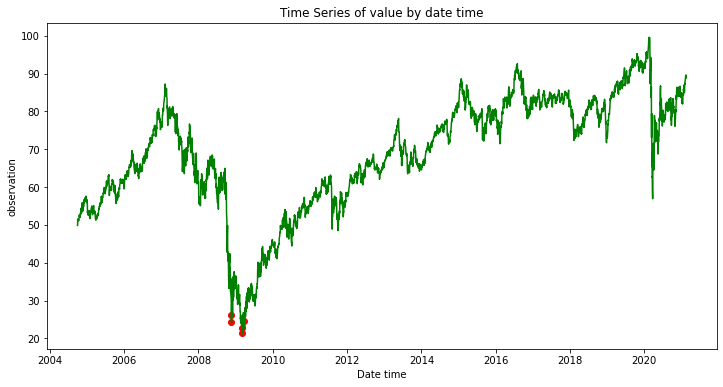

In [260]:
figure, axes = plt.subplots(figsize=(12, 6))
axes.plot(adf['Date'], adf['observation'], color='g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Date'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')